# Práctica ECI 2019 - Clasificadores Probabilísticos


## Calibración Extrínseca de Clasificadores Binarios Basados en Scores

## Carga de datos

In [1]:
from scipy.io import loadmat
try:
    data = loadmat('./data/2019_datos_calibracion_sistemas.mat')
    # Training data
    sistema4_Hp_train = data['sistema4_Hp_train'][0]
    sistema4_Hd_train = data['sistema4_Hd_train'][0]
    # Data to calibrate
    sistema4_Hp_test  = data['sistema4_Hp_test'][0]
    sistema4_Hd_test  = data['sistema4_Hd_test'][0]
except:
    print("Error loading data file")

In [2]:
# First 10 elements of Hp train
sistema4_Hp_train[0:10]

array([2.18596535e+00, 3.22865750e-02, 4.49668372e+02, 2.27915172e-01,
       6.70030342e+02, 2.97482289e+03, 7.91251459e+00, 3.85073734e+00,
       9.77541955e-01, 6.76085047e-01])

## Datos de entrada - Histogramas

* datos de **entrenamiento** (azul)
* datos de **test** a calibrar (rojo)

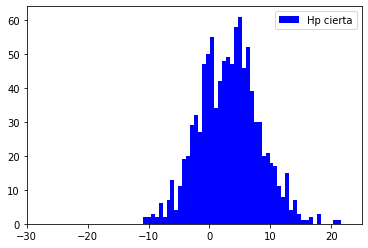

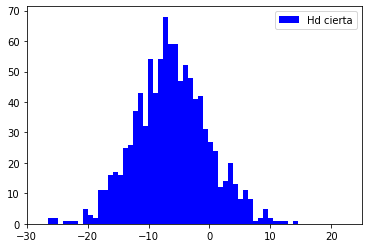

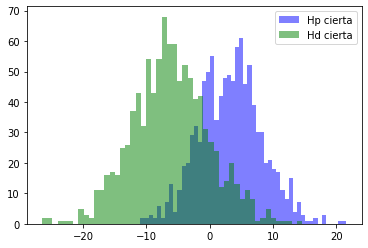

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# Hp cierta
plt.hist(np.log(sistema4_Hp_train), bins=50, label='Hp cierta', color='b')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hd cierta
plt.hist(np.log(sistema4_Hd_train), bins=50, label='Hd cierta', color='b')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_train), bins=50, label='Hp cierta', color='b', alpha=0.5)
plt.hist(np.log(sistema4_Hd_train), bins=50, label='Hd cierta', color='g', alpha=0.5)
plt.legend()
plt.show()

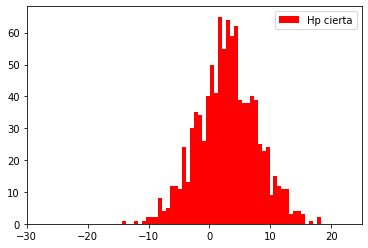

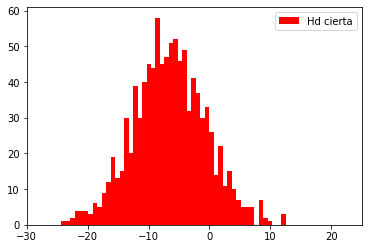

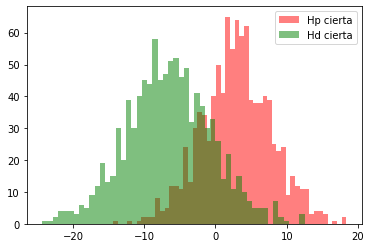

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# Hp cierta
plt.hist(np.log(sistema4_Hp_test), bins=50, label='Hp cierta', color='r')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hd cierta
plt.hist(np.log(sistema4_Hd_test), bins=50, label='Hd cierta', color='r')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_test), bins=50, label='Hp cierta', color='r', alpha=0.5)
plt.hist(np.log(sistema4_Hd_test), bins=50, label='Hd cierta', color='g', alpha=0.5)
plt.legend()
plt.show()

# Pregunta:

> ¿Cree que los datos de entrenamiento utilizados en la prueba van a modelar bien la función de calibración a utilizar con los datos de prueba? Razone su respuesta.

Sí, ya que muestran distribuciones similares, tanto en media como en dispersión.

Más directamente:

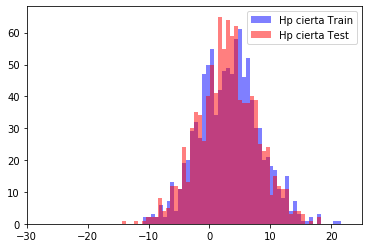

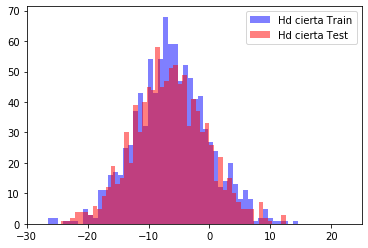

In [5]:
# Hp cierta train
plt.hist(np.log(sistema4_Hp_train), bins=50, label='Hp cierta Train', color='b', alpha=0.5)
plt.hist(np.log(sistema4_Hp_test),  bins=50, label='Hp cierta Test',  color='r', alpha=0.5)
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hd cierta train
plt.hist(np.log(sistema4_Hd_train), bins=50, label='Hd cierta Train', color='b', alpha=0.5)
plt.hist(np.log(sistema4_Hd_test),  bins=50, label='Hd cierta Test',  color='r', alpha=0.5)
plt.xlim([-30, 25])
plt.legend()
plt.show()

## Calibración mediante regresión logística (o calibración Platt)

Realice la calibración del sistema mediante regresión logística utilizando la siguiente función:

#### Funciones

Defino funciones necesarias, usando los archivos de Matlab brindados en el curso como guía para replicar el funcionamiento en Python.

Dejo datos y descripciones de los autores de los mismos: Prof. Daniel Ramos y Niko Brummer.

In [6]:
def cg_dir(old_dir, grad, old_grad):
    # Compute the new conjugate direction
    g = grad
    grad = grad.flatten()
    old_grad = old_grad.flatten()

    delta = grad - old_grad
    den = np.matmul(np.transpose(old_dir), delta)
    if den==0:
        direc = g*0
    else:
        # Hestenes-Stiefel
        beta = np.matmul(np.transpose(grad), delta) / den
        # Polak-Ribiere
        #beta = np.matmul(np.transpose(-grad),(grad - old_grad)) / np.matmul(np.transpose(old_grad),old_grad)
        # Fletcher-Reeves
        #beta = -np.matmul(np.transpose(grad),grad) / np.matmul(np.transpose(old_grad), old_grad)
        direc = g - beta * old_dir
    return direc

In [7]:
#  Train Linear fusion with prior-weighted Logistic Regression objective.
#  The fusion output is encouraged by this objective to be a well-calibrated log-likelihood-ratio.
#  I.E., this is simultaneous fusion and calibration.
#
#  Usage:
#    w = [w,minimumConvergenceCriterium] =
#    train_llr_fusion_convergenge_threshold(targets,non_targets,threshold,prior)
#    w = [w,minimumConvergenceCriterium] =
#    train_llr_fusion_convergenge_threshold(targets,non_targets,threshold)
#   
#  Input parameters:
#    targets:     a [d,nt] matrix of nt target scores for each of d systems to be fused. 
#    non_targets: a [d,nn] matrix of nn non-target scores for each of the d systems.
#    threshold:   a scalar thrshold for the convergence of the CG
#                 algorithm. DEFAULT VALUE 1e-5.
#    prior:       (optional, default = 0.5), a scalar parameter between 0 and 1. 
#                 This weights the objective function, by replacing the effect 
#                 that the proportion nt/(nn+nt) has on the objective.
#                 For general use, omit this parameter (i.e. prior = 0.5).
#                 For NIST SRE, use: prior = effective_prior(0.01,10,1)
#
#  Output parameters:
#    w: a vector of d+1 fusion coefficients. 
#         The first d coefficients are the weights for the d input systems.
#         The last coefficient is an offset (see below).
#    minimumConvergenceCriterium: the minimum of the stopping criterium of
#         the CG algorithm for this case. It only will have utility in
#         cases when convergence is not achieved. For other cases, a value 
#         higher than the threshold will be returned.
#
#  Fusion of new scores:
#    see: LIN_FUSION.m
#
#  This code is an adapted version of the m-file 'train_llr_fusion.m' as 
#  included in the FoCal toolkit by Niko Brümmer:
#  www.dsp.sun.ac.za/~nbrummer/focal/index.htm
#
#  Author: Daniel Ramos, November 2006.

def train_llr_fusion_convergence_threshold(targets, non_targets, threshold=1e-5, prior=0.5):
    nt = np.size(targets)
    nn = np.size(non_targets)
    prop = nt / (nn + nt)
    weights = np.concatenate(((prior/prop) * np.ones(nt),
                             ((1-prior)/(1-prop)) * np.ones(nn))).reshape(1, -1)


    x = np.asarray([np.concatenate([targets, -non_targets]),
                    np.concatenate([np.ones(nt), -np.ones(nn)])])
    w = np.zeros(np.shape(x)[0]).reshape(-1, 1) # adds dummy dimension
    lp = np.log((prior/(1-prior)))
    offset = lp * np.concatenate([np.ones(nt), -np.ones(nn)]).reshape(1, -1)

    d, n = np.shape(x)
    old_g = np.zeros(np.size(w))
    
    iterations=1000
    minimumConvergenceCriterium=1000000
    warning=1
    
    for i in range(1, iterations):
        old_w = w

        if ((np.matmul(np.transpose(w), x) + offset > 100).all() and (warning==1)):
            print('WARNING: logistic regression training may diverge!.')
            print('  Possible causes:')
            print('   -- Input scores are too big! Try score normalization.')
            print('   -- Training scores are separable.')
            warning=0
        s1 = 1. / (1 + np.exp(np.matmul(np.transpose(w),x) + offset))

        g = np.matmul(x , np.transpose(np.multiply(s1, weights))) # <<<<< aca parece haber un error

        if i == 1:
            u = g
        else:
            u = cg_dir(u, g, old_g)

        # line search along u
        ug = np.matmul(np.transpose(u) , g)
        ux = np.matmul(np.transpose(u) , x)

        a = np.multiply(np.multiply(weights, s1), (1-s1))

        uhu = np.matmul(np.power(ux, 2), np.transpose(a))
        w = w + (ug/uhu)*u
        old_g = g
        print('Convergence condition {}'.format(max(abs(w - old_w))))
        if max(abs(w - old_w)) < minimumConvergenceCriterium:
            minimumConvergenceCriterium = np.max(abs(w - old_w))
        if max(abs(w - old_w)) < threshold:
            break
    if i == iterations:
        print('Convergence not achieved in {} iterations.'.format(iterations))

    return w, minimumConvergenceCriterium

In [8]:
# Calibrates using linear logistic regression.
#
# -- INPUT --
# * scoresTargetTrain:    (1xNt) Target scores used for calibration training (natural scale).
# * scoresNonTargetTrain: (1xNn) Non-target scores used for calibration training (natural scale).
# * scoresTargetTest:           (1xN)  Scores target to be calibrated (matural scale).
# * scoresNonTargetTest:           (1xN)  Scores nonTarget to be calibrated (natural scale).
# * prior:                Prior probability for the logistic regression
#                         objective. Default value: 0.5
#
# -- OUTPUT --
# * llrs:                 (1xN)  Output calibrated llrs.
#
# This software makes use of the FoCal toolkit
# (see http://www.dsp.sun.ac.za/~nbrummer/focal)
#
# Author: Daniel Ramos, November 2006.
#
# It has been detected that in some cases the convergence of the FoCal CG
# algorithm diverges or is not achieving a good optimum. We use a
# provisional conservative training strategy, which is not intended to be a
# definitive solution.

def calibracion_lineal_curso(scoresTargetTrain, scoresNonTargetTrain, scoresTargetTest, scoresNonTargetTest, prior=0.5):
    print('Training with a conservative threshold...')
    conservativeThreshold = 1e-10
    w, minimumConvergence = train_llr_fusion_convergence_threshold(np.log(scoresTargetTrain),
                                                                   np.log(scoresNonTargetTrain),
                                                                   conservativeThreshold, prior)
    if minimumConvergence >= conservativeThreshold:
        print(' ')
        print('WARNING: Convergence not achieved with a conservative threshold.')
        print('  Check the convergence of the algorithm (see "a posteriori" APE plot).')
        print(' ')
        print('Training with the minimum convergence value achieved in the previous step...')
        w = train_llr_fusion_convergence_threshold(np.log(scoresTargetTrain),
                                                   np.log(scoresNonTargetTrain),
                                                   conservativeThreshold, prior)
    else:
        print('Done!')
    scores = np.log(scoresTargetTest)
    linear_fusion = np.matmul(np.transpose(w), [scores, np.ones(np.shape(scores))]) 
    targetLrs = np.exp(linear_fusion)
    
    scores = np.log(scoresNonTargetTest)
    linear_fusion = np.matmul(np.transpose(w) , [scores, np.ones(np.shape(scores))])
    
    nonTargetLrs = np.exp(linear_fusion)

    # PLOTTING FUNCTIONS
    # Sorting scores and LRs separately is OK because the trasformation is monotonic
    plt.plot(np.sort(np.concatenate((scoresTargetTest, scoresNonTargetTest))),
             np.sort(np.concatenate((targetLrs, nonTargetLrs), axis=1))[0],
             label='Escala Natural')
    plt.xlabel('LR de entrada')
    plt.ylabel('LR de salida')
    plt.legend()
    plt.show()
    
    plt.plot(np.sort(np.log10(np.concatenate((scoresTargetTest, scoresNonTargetTest)))),
             np.sort(np.log10(np.concatenate((targetLrs, nonTargetLrs), axis=1))[0]),
             label='Escala Log10')
    plt.xlabel('log10(LR) de entrada')
    plt.ylabel('log10(LR) de salida')
    plt.legend()
    plt.show()
    
    return targetLrs, nonTargetLrs

#### Calibración:

Training with a conservative threshold...
Convergence condition [0.17144455]
Convergence condition [0.31688769]
Convergence condition [0.08827184]
Convergence condition [0.05517147]
Convergence condition [0.03693161]
Convergence condition [0.00371291]
Convergence condition [0.00490386]
Convergence condition [3.35182655e-05]
Convergence condition [7.38391998e-05]
Convergence condition [5.39317263e-09]
Convergence condition [1.63650182e-08]
Convergence condition [5.55111512e-17]
Done!


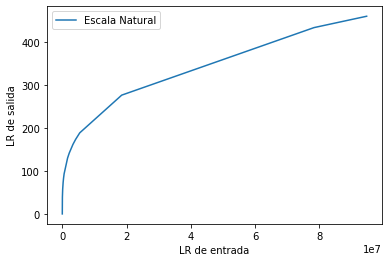

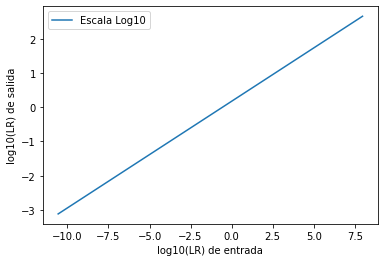

In [9]:
sistema4_Hp_calibrado_lineal, sistema4_Hd_calibrado_lineal = calibracion_lineal_curso(sistema4_Hp_train,
                                                                                      sistema4_Hd_train,
                                                                                      sistema4_Hp_test,
                                                                                      sistema4_Hd_test)

# Pregunta:
> Observe la función de calibración obtenida. Coméntela con sus compañeros y el profesor. ¿Cuál cree que son sus principales ventajas e inconvenientes?

* Limitará "la fuerza" del LR de entrada (considera la falta de datos)

# Histogramas log-LR

### Antes de calibrar

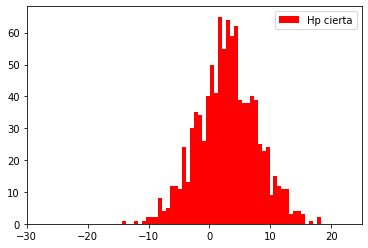

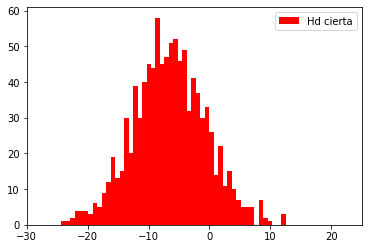

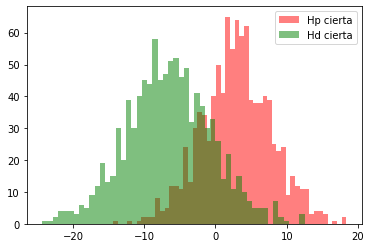

In [23]:
# Hp cierta
plt.hist(np.log(sistema4_Hp_test), bins=50, label='Hp cierta', color='r')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hd cierta
plt.hist(np.log(sistema4_Hd_test), bins=50, label='Hd cierta', color='r')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_test), bins=50, label='Hp cierta', color='r', alpha=0.5)
plt.hist(np.log(sistema4_Hd_test), bins=50, label='Hd cierta', color='g', alpha=0.5)
plt.legend()
plt.show()

### Luego de calibrar

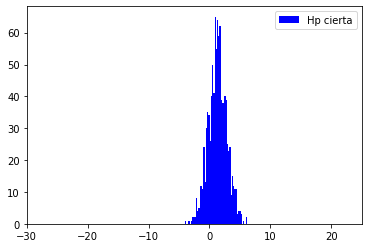

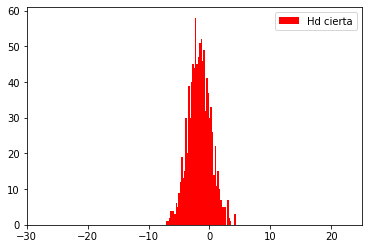

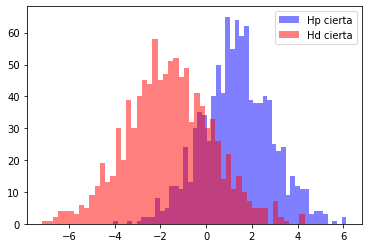

In [24]:
# Hp cierta
plt.hist(np.log(sistema4_Hp_calibrado_lineal[0]), bins=50, label='Hp cierta', color='b')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hd cierta
plt.hist(np.log(sistema4_Hd_calibrado_lineal[0]), bins=50, label='Hd cierta', color='r')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_calibrado_lineal[0]), bins=50, label='Hp cierta', color='b', alpha=0.5)
plt.hist(np.log(sistema4_Hd_calibrado_lineal[0]), bins=50, label='Hd cierta', color='r', alpha=0.5)
plt.legend()
plt.show()

# Pregunta:

> Comente el efecto de la calibración en las Tippett obtenidas.

Se nota una gran diferencia en la dispersión de las distribuciones:
- donde antes de calibrar el rango estaba entre $(-30,25)$, 
- luego de calibrar se reducen a $(-7,6)$

Aunque mantienen su forma relativa:

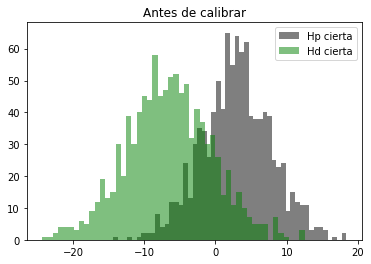

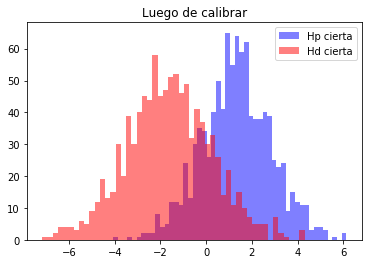

In [25]:
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_test), bins=50, label='Hp cierta', color='k', alpha=0.5)
plt.hist(np.log(sistema4_Hd_test), bins=50, label='Hd cierta', color='g', alpha=0.5)
plt.legend()
plt.title('Antes de calibrar')
plt.show()
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_calibrado_lineal[0]), bins=50, label='Hp cierta', color='b', alpha=0.5)
plt.hist(np.log(sistema4_Hd_calibrado_lineal[0]), bins=50, label='Hd cierta', color='r', alpha=0.5)
plt.title('Luego de calibrar')
plt.legend()
plt.show()

# Applied Probability of Error (APE) plot

> Analice ahora la APE antes y después de calibrar.

**Observación**

No fue posible terminar de implementar la función graficadora de la curva APE.

Estimo que es alguna diferencia entre las funciones equivalentes entre Matlab y Numpy/Scipy

Como son (en caso de que sea de interés):

* Argsort de Matlab define empates con prioridad a la primera aparicipón de izquierda a derecha.
* Argsort de Numpy da prioridad al último (o al primero de derecha a izquierda).

* Operaciones entre matrices requieren de mucha atención a sutiles diferencias.

* Y el más conocido: Los índices de Matlab que comienzan en 1.

Debuggeando los valores entre operaciones, suelen mantenerse a la par con los obtenidos en Matlab hasta varios decimales, pero en ciertas partes existen diferencias de órden o números completamente diferentes.

Dejo el código y los resultados, pero el análisis será sobre los gráficos obtenidos en Matlab:

In [26]:
def pav(y):
    #PAV: Pool Adjacent Violators algorithm. Non-paramtetric optimization subject to monotonicity.
    #
    # ghat = pav(y)
    # fits a vector ghat with nondecreasing components to the 
    # data vector y such that sum((y - ghat).^2) is minimal. 
    # (Pool-adjacent-violators algorithm).
    # 
    # Author: This code is a simplified version of the 'IsoMeans.m' code made available 
    # by Lutz Duembgen at:
    # http://www.imsv.unibe.ch/~duembgen/software
    n = len(y)

    index = np.zeros(np.shape(y))
    lenght = np.zeros(np.shape(y))
    # An interval of indices is represented by its left endpoint 
    # ("index") and its length "len" 
    ghat = np.zeros(np.shape(y))

    ci = 0
    index[ci] = 0
    lenght[ci] = 1
    ghat[ci] = y[0]
    # ci is the number of the interval considered currently.
    # ghat[ci] is the mean of y-values within this interval.
    for j in range(1, n):
        # a new index interval, {j}, is created:
        ci = ci+1
        index[ci] = j
        lenght[ci] = 1
        ghat[ci] = y[j]
        while ci >= 1 and ghat[max(ci-1,0)] >= ghat[ci]:
            # "pool adjacent violators":
            nw = lenght[ci-1] + lenght[ci]
            ghat[ci-1] = ghat[ci-1] + (lenght[ci] / nw) * (ghat[ci] - ghat[ci-1])
            lenght[ci-1] = nw
            ci = ci-1

    # Now define ghat for all indices:
    while n >= 0:
        for j in range(int(index[ci]), int(n)):
            ghat[j] = ghat[ci]
        n = index[ci]-1
        ci = ci-1

    return ghat

In [27]:
# OPT_LOGLR: Non-parametric optimization of score to log-likelihood-ratio mapping. 
#
#   Input Parameters
#     tar_scores, nontar_scores: arrays of target and non-target scores
#
#   Output Parameters
#     tar_llrs, nontar_llrs: arrays of corresponding log-likelihood ratios, 
#     one for each input score.
#
#   option
#     'laplace': (default) avoids logLR's of infinite magnitude, see below.  
#     'raw': allows logLR's of infinite magnitude  
#
#   Description:
#     The output log-LR values are non-parametrically and (almost) independently optimized, 
#     subject only to the constraint that the mapping from score to log-LR must be 
#     non-decreasing. 
#     Remarkably the mapping thus obtained is empirically optimal (on the input data and subject 
#     to the constraint) for any cost function at 
#     any prior. 
#     
#     N.B. but note that a mapping thus obtained on training data cannot of course be assumed 
#     to have the same universal optimality on new test data. The primary application of this 
#     procedure is to obtain a TEST STANDARD similar to "minimum Cdet". Minimum Cdet is based 
#     on a threshold optimized on the evaluation data, again subject only to a non-decreasing 
#     mapping. 
#
#     The mapping obtained here is a generalization of the minimum Cdet threshold: 
#     The whole score to LR mapping is optimized. The minimum Cdet threshold can be read 
#     from this mapping, but we can also read multiple thresholds for more complicated 
#     applications that for example require a decision of the form Accept/Reject/Undecided.
#
#     Note on empirical test error:
#       A straight-forward implementation leads to log-LR values of infinite 
#       magnitude for 
#       (a) all target scores that exceed the largest non-target score
#       (b) all non-target scores smaller than the smallest target score. 
#       The following is a strategy to assign finite log-LR values to these cases. 
#       Setting option='raw' switches this mechanism off and will most probably result 
#       in some infinite values.
#
#       Laplace's rule of succession:
#         Before seeing any scores, our prior knowledge about target scores states:
#         - Target scores may be concentrated in a small score range,
#         - but to keep the test procedure objective, we don't want to make any assumptions 
#         about where this concentration is. (The score mean can be anywhere.)
#         One way to state this mathematically is:
#           - Given any finite score threshold t, we define theta = P(score > t). 
#           - Since we don't know where the score is concentrated we have a uniform prior over 
#         the parameter theta: P(theta|t) = 1, for any t.
#         Now given this distribution, we can count the number of target scores that 
#         exceed a threshold t:
#         Let there be N target scores in total of which M exceed the threshold t. 
#         Then the Bayesian predictive probability to get another score above 
#         t is (M+1)/(N+2), instead of the usual M/N. This is known as the rule of succession.
#         - See e.g. http://en.wikipedia.org/wiki/Rule_of_succession.
#         This rule can be effectively implemented, for every value of t, by simply adding a 
#         dummy target score at each of -inf and +inf. 
#         The same is applied to non-target scores. By doing this we are acknowledging the fact 
#         that there is a possibility to get scores outside the ranges seen in the test data.
#
#         P.S.1. A similar strategy was used in 
#         Platt, "Probabilistic Outputs for Support Vector Machines... "
#         http://research.microsoft.com/~jplatt/abstracts/SVprob.html
#
#         P.S.2. Try this when plotting DET curves! It stops DET's from curling to the axes when the 
#         data is sparse, but leaves well-populated regions unchanged. 
# Author: Niko Brummer, Spescom Datavoice.
#         nbrummer@za.spescom.com
# Disclaimer: This code is freely available for any non-commercial purpose, but the author and 
# his employer do not accept any responsibility for any consequences resulting from the use thereof.
# (E.g. getting an EER=50# at the NIST SRE.) 
#
# But if this code does prove useful, we would appreciate citation of the following article:
#   Niko Brummer and Johan du Preez, "Application-Independent Evaluation of Speaker Detection", 
#   Computer Speech and Language, to be published, 2005. 

def opt_loglr(tar_scores, nontar_scores, option='laplace'):
    Nt = len(tar_scores)
    Nn = len(nontar_scores)
    N = Nt + Nn

    # The 'sort' function in Matlab (CONTRARY to Numpy) preserves the indexing ordering for values which are exactly the same.
    # Thus, putting the target scores first in the ordering chooses the pesimistic option: if a target
    # and a non-target score have the same value, the target score will be assumed to be lower.
    # This is necessary so that min_cllr(0,0) returns 1, not 0. 
    # It boils down to saying that when a target and a non-target have the same
    # score, it is bad, not good.
    #scores = np.concatenate((tar_scores, nontar_scores))
    # Modification from original:
    # nontarget first to use numpy argsort (on ties: chooses last one)
    scores = np.concatenate((nontar_scores, tar_scores))
    #Pideal = np.concatenate((np.ones(Nt), np.zeros(Nn)))  #ideal, but non-monotonic posterior
    Pideal = np.concatenate((np.zeros(Nn), np.ones(Nt)))
    perturb = np.argsort(scores) # get ordered indices
    scores = scores[perturb]     # scores in that order
    Pideal = Pideal[perturb]     # Pidela in that order

    if option=='laplace':
        Pideal = np.concatenate(([1, 0], Pideal, [1, 0])).flatten()
        # The extra targets and non-targets at scores of -inf and +inf effectively 
        # implement Laplace's rule of succession to avoid log LRs of infinite magnitudes. 
        #
    # Pool Adjacent Violators Algorithm. Gets a non-decreasing posterior Popt "closest" to Pideal.
    # Remarkably this is valid for "closeness" as defined by any proper scoring rule.
    # It will therefore minimize the cost of decisions based on Popt, for any cost-based penalty.
    Popt = pav(Pideal) 

    if option=='laplace':
    # lose the extras
      Popt = Popt[2:-2]

    #posterior to loglr
    #This LR is prior-independent in the sense that if we weight the data with a synthetic prior, 
    # it makes no difference to the optimizing LR mapping. 
    # (A synthetic prior DOES change Popt: The posterior log-odds changes by an additive term. But this 
    # this cancels again when converting to log LR. )

    #state = warning
    #warning off  # otherwise 'raw' option would produce 'log(0)' warnings
    # Agrego eps para evitar divisiones por cero.
    eps=1e-6
    posterior_log_odds = np.log(Popt + eps) - np.log(1-Popt + eps)

    # If same size, = 0
    log_prior_odds = np.log((Nt) / (Nn))
    # log_prior_odds=0.5

    llrs = posterior_log_odds - log_prior_odds
    llrs = llrs + np.arange(1, N+1) * 1.0e-6 / N # to preserve monotonicity. This ensures opt_loglr is idempotent.

    #unsort and unpack
    llrs[perturb] = llrs
    nontar_llrs = llrs[0:Nt]  # same order as at the beggining
    tar_llrs = llrs[Nt:Nn+Nt] # or llrs[Nt:]

    return tar_llrs, nontar_llrs

In [28]:
# APE_PLOT_BN: Applied-Probability-of-Error plot. 
#          Displays the goodness of log-likelihood-ratio detector outputs, 
#          for one or more detector systems.  
#          The x-axis is in logaritmic units (BASE 10)
#          BUT the input LLR values are still in natural logarithms
#
# Usage: APE_PLOT(['sys1', [tar_llrs1,nontar_llrs1] ],
#                 ['sys2', [tar_llrs2,nontar_llrs2] ] , ...)   
#    
# Input parameters: One or more entries, one entry per system under evaluation.
#      'sys1': A string label for system1
#      tar_llrs1: An array of the target LLR outpouts of system1
#      nontar_llrs1: An array of the non-target LLR outpouts of system1.
#
# This routine generates two plots per system, APE-plot on top, and Cllr-plot below: 
# 
#   The top plot is the APE-plot, having three APE-curves. Each gives (y-axis) the  
#   error-rate of using the following three inputs to make Bayes decisions:
#   (a) Costs: Cmiss = Cfa = 1
#   (b) The target prior, given as 'logit prior' on the x-axis.
#   (c) log-likelihood-ratios, which are different for each plot:
#
#   	   RED: The 'actual' log-likelihood-ratios as supplied by the system under evaluation.
#        GREEN: Optimized log-likelihood-ratios as optimized by the evaluator (this code), 
#               on these given (evaluation) data. The optimization is subject only to a 
#               monotonicity constraint on the mapping between the actual and optimized 
#               llr values. 
#        BLACK(dashed): llrs = zeros. This forms the reference system which makes Bayes 
#                        decisions based on (a) and (b) only.
#        
#   Note 1: The APE-plot further shows a magenta dashed vertical line to indicate where the 
#           traditional NIST operating point is (at -2.29). The red and green error-rates 
#           at -2.29 are scaled versions of the traditional CDET and 'min CDET' values.
#   Note 2: The max of the green curve is also the EER.
#
#
# The bottom (Cllr) plot is a bar-graph giving (scaled) integrals under the green and red curves. 
# The (scaled) area under the reference (dashed black) curve is one. The integrals are performed 
# analytically over the whole x-axis (logit prior) from -inf to inf. The bar graph gives:
#   RED+GREEN: (Actual) total error-rate over the whole range of applications. 
#              This is CLLR(tar_llrs,nontar_llrs). 
#              Note: 0 <= Cllr <= inf
#   GREEN: (Minimum) total error-rate over the whole range of applications. This is the 
#          performance that the system under evaluation could have obtained with a 
#          perfect (for this data) score-to-llr calibration.
#          This is MIN_CLLR(tar_llrs,nontar_llrs). 
#          Note: 0 <= MIN_CLLR <= 1
#   RED:   This is the area between the red and the green APE-curves and is the measure of how
#          well the score to log-likelihood-ratio mapping is 'calibrated'. 
#          This is CLLR_CAL(tar_llrs,nontar_llrs).
#          Note: 0 <= CLLR_CAL <= inf
#
# Author: Niko Brummer, Spescom Datavoice.
# Disclaimer: This code is freely available for any non-commercial purpose, but the author and 
# his employer do not accept any responsibility for any consequences resulting from the use thereof.
# (E.g. getting an EER=50# at the NIST SRE.) 
#
# But if this code does prove useful, we would appreciate citation of the following article:
#   Niko Brummer and Johan du Preez, "Application-Indepent Evaluation of Speaker Detection"
#   Computer Speech and Language, to be published, 2005. 


def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def neglogsigmoid(log_odds):
    neg_log_p = -log_odds
    e = np.exp(-log_odds)
    neg_log_p[e < e+1] = np.log(1 + e[e < e+1])
    return neg_log_p

def neglogsigmoid2(log_odds):
    return -np.log(sigmoid(log_odds))

def cllr(tar_llrs, nontar_llrs):
    # target trials 
    c1 = np.mean(neglogsigmoid(tar_llrs)) / np.log(2)
    # non_target trials 
    c2 = np.mean(neglogsigmoid(-nontar_llrs)) / np.log(2)
    # Cllr
    cllr = (c1+c2)/2
    return cllr

# Pe = bayes_error_rate(tar_llrs, nontar_llrs, prior_log_odds);
#
#   Pe is the probability of error, when Bayes decisions are made with the following three inputs:
#   (a) Cmiss = Cfa = 1
#   (b) The given prior
#    (c) The log-likelihood-ratios, given separately here for target and non-target trials
#
#    Input parameters: 
#      tar_llrs: an array of log-likelihood-ratios for target trials
#      nontar_llrs: an array of log-likelihood-ratios for non-target trials
#      prior_log_odds: an array representing a range over the prior, specified as log-odds
#
#    Output: Pe is an array of the same size as prior_log_odds. I.E. each Pe value corresponds
#          to one value of the prior.
def bayes_error_rate(tar_llrs, nontar_llrs, prior_log_odds):
    pmiss = np.zeros(len(prior_log_odds))
    pfa = np.zeros(len(prior_log_odds))
    # loop over different priors
    for i in range(len(prior_log_odds)):
        # target trials 
        posterior = sigmoid(tar_llrs + prior_log_odds[i])
        #error-rate of Bayes decisions
        pmiss[i] = np.mean((1 - np.sign(posterior - 0.5)) / 2) 
        # non_target trials 
        posterior = sigmoid(nontar_llrs + prior_log_odds[i])
        # error_rate of Bayes decisions
        pfa[i] = np.mean((1 - np.sign(0.5 - posterior)) / 2) 
    # Combine with prior-weighting, and we're done.
    Pe = np.multiply(pmiss, sigmoid(prior_log_odds)) + np.multiply(pfa, sigmoid(-prior_log_odds))
    return Pe

def ape_plot_log10(log_lr_hp, log_lr_hd):
    # plo = prior_log_odds
    # This range was chosen to show more or less the range of interest for current levels of
    # speaker detection performance. If systems get better and evaluation data more, this range 
    # can be enlarged.
    # The theoretcal range is the whole real line.
    # np.arange(start, end, step)
    plo = np.arange(-7, 7, 0.1)

    clog = 0
    minclog = 0
    eer = 0

    tar_opt_llrs, nontar_opt_llrs = opt_loglr(log_lr_hp, log_lr_hd, 'raw')
    tar_llrs = log_lr_hp
    nontar_llrs = log_lr_hd

    clog = cllr(tar_llrs, nontar_llrs)
    
    minclog = cllr(tar_opt_llrs, nontar_opt_llrs)
    
    Pe    = bayes_error_rate(log_lr_hp, log_lr_hd, plo)
    minPe = bayes_error_rate(tar_opt_llrs, nontar_opt_llrs, plo)
    refPe = bayes_error_rate(0, 0, plo)
    
    # Curvas APE
    plt.plot((1/np.log(10)*plo), Pe, 'b', label='Pe')
    plt.plot(((1/np.log(10))*plo), minPe, 'r--', label='min Pe')
    plt.plot((1/np.log(10)*plo), refPe, 'g:', label='ref Pe')
    plt.ylabel('P(error)')
    plt.xlabel('logit (BASE 10) prior')
    eer = max(eer, max(Pe))
    plt.axis([min(plo/np.log(10)),
              max(plo/np.log(10)),
              0, eer*1.5])
    plt.grid()
    plt.legend()
    plt.show()

    # Barras de loss
    plt.bar([0], height=minclog, align='center', label='discrimination loss')
    plt.bar([0], height=(clog-minclog), align='center', label='calibration loss')
    plt.grid()
    plt.legend()

    plt.ylabel('C_[llr] [bits]')
    plt.xticks([])

    plt.show()

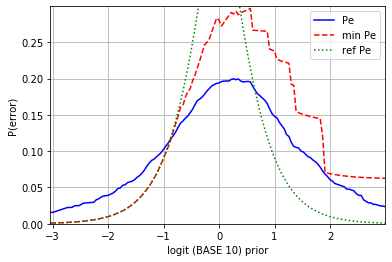

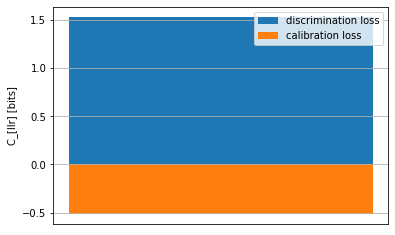

In [29]:
ape_plot_log10(np.log(sistema4_Hp_test),
               np.log(sistema4_Hd_test))

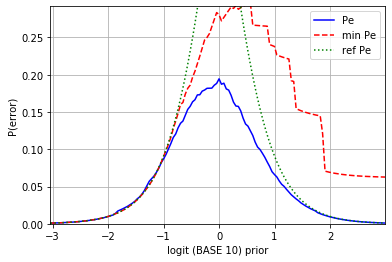

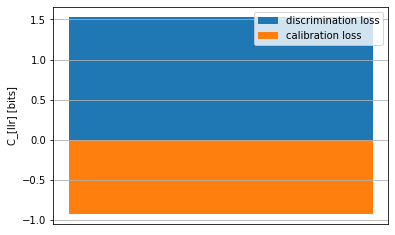

In [30]:
ape_plot_log10(np.log(sistema4_Hp_calibrado_lineal[0]),
               np.log(sistema4_Hd_calibrado_lineal[0]))

# Pregunta:
> Comente el efecto de la calibración en las APEs obtenidas.

Usando Matlab:

## Curvas APE
### Antes de calibrar
![ape-lineal-antes](./img/ape-lineal-antes.png)
### Luego de de calibrar
![ape-lineal-calibrado](./img/ape-lineal-calibrado.png)

**Efectos de calibración:**

* Se observa como el Bayes Error Rate (Pe, curva azul de area **Cross Entropy Loss** ($Cllr$)) se "acerca" al mínimo error (curva rayada $minCllr$)
* El area entre la curva azul y la rayada es la $calibration C_{llr}$
* El error de calibración se reduce considerablemente (área antes mencionada)


## Calibración mediante PAV (o Regresión Isotónica)

In [31]:
# Calibrates using PAV.
#
# -- INPUT --
# * scoresTargetTrain:    (1xNt) Target scores used for calibration training (natural scale).
# * scoresNonTargetTrain: (1xNn) Non-target scores used for calibration training (natural scale).
# * scoresTargetTest:     (1xN)  Scores target to be calibrated (matural scale).
# * scoresNonTargetTest:  (1xN)  Scores nonTarget to be calibrated (natural scale).
#
# -- OUTPUT --
# * llrs:                 (1xN)  Output calibrated llrs.
#
# This software makes use of the FoCal toolkit
# (see http://www.dsp.sun.ac.za/~nbrummer/focal)
#
# Author: Daniel Ramos, November 2006.

import numpy as np
from scipy.interpolate import interp1d

def calibration_PAV(scoresTargetTrain, scoresNonTargetTrain, scoresTest, method='raw'):
    llrTargetTrain, llrNonTargetTrain = opt_loglr(scoresTargetTrain, scoresNonTargetTrain)

    mappingX = np.concatenate((scoresTargetTrain, scoresNonTargetTrain))
    mappingY = np.concatenate((llrTargetTrain, llrNonTargetTrain))

    perturb = np.argsort(mappingX)
    mappingX = mappingX[perturb]
    mappingY = mappingY[perturb]

    if method=='raw':
        # Elimination of same values of the mapping. Required by interp1.
        mappingX, nonRepeatedValuesIndex = np.unique(mappingX, return_index=True)
        mappingY = mappingY[nonRepeatedValuesIndex]

        # Because of the opt_llr function, the score-llr mapping will
        # have a very small slope in order to guarantee the idempotence of PAV
        # (appliying PAV to the output of PAV will give the same solution).
        # The output llrs will then need to have that small slope also in order to
        # preserve that idempotence. That is the reason of a linear
        # interpolation.
        #llrs = interp1(mappingX, mappingY, scoresTest, 'linear', 'extrap')
        llrs = interp1d(mappingX, mappingY, kind='linear',
                        fill_value='extrapolate')(scoresTest)
    else:
        # llrs=scoreToLlrPAVMappingCentroidInterpolation(scoresTest,mappingX,mappingY,method)
        # Interpolation of the centroids of the bins.
        peakThreshold=0.001

        # Centroid interpolation of the PAV mapping
        # We use peak detection to find the centroids
        yLlrsMappingDifferences = diff(mappingY)

        peakIndexes = [1, find(yLlrsMappingDifferences > peakThreshold), length(mappingX)]

        xScoresMappingCentroids = zeros(1,length(peakIndexes)+1)
        xScoresMappingCentroids[0] = mappingX[0]
        xScoresMappingCentroids[length(xScoresMappingCentroids)] = mappingX[length(mappingX)]

        yLlrsMappingCentroids = zeros(1, length(peakIndexes)+1)
        yLlrsMappingCentroids[length(yLlrsMappingCentroids) ] = mappingY(length(mappingY))
        yLlrsMappingCentroids[length(yLlrsMappingCentroids)-1] = mappingY(length(mappingY)-1)

        for countPeaks in range(2, len(peakIndexes)):
            xScoresMappingCentroids[countPeaks]=(mappingX(peakIndexes(countPeaks))+mappingX(peakIndexes(countPeaks-1)))/2
            yLlrsMappingCentroids[countPeaks-1]= mappingY(peakIndexes(countPeaks-1))

        
        llrs = interp1d(xScoresMappingCentroids, yLlrsMappingCentroids,
                        kind='linear', fill_value='extrapolate')(scoresTest)
    return llrs, mappingX, mappingY

In [32]:
def calibracion_PAV_curso(scoresTargetTrain, scoresNonTargetTrain, scoresTargetTest, scoresNonTargetTest, prior=0.5):
    
    targetLrs,_,_ = calibration_PAV(np.log(scoresTargetTrain),
                                    np.log(scoresNonTargetTrain),
                                    np.log(scoresTargetTest))
    targetLrs = np.exp(targetLrs)

    nonTargetLrs, _,_ = calibration_PAV(np.log(scoresTargetTrain),
                                        np.log(scoresNonTargetTrain),
                                        np.log(scoresNonTargetTest))
    nonTargetLrs = np.exp(nonTargetLrs)
    
    # PLOTTING FUNCTIONS
    # Sorting scores and LRs separately is OK because the trasformation is monotonic
    plt.plot(np.sort(np.concatenate((scoresTargetTest, scoresNonTargetTest))),
             np.sort(np.concatenate((targetLrs, nonTargetLrs))),
             label='Escala Natural', color='b')
    plt.xlabel('LR de entrada')
    plt.ylabel('LR de salida')
    plt.legend()
    plt.show()
    
    plt.plot(np.sort(np.log10(np.concatenate((scoresTargetTest, scoresNonTargetTest)))),
             np.sort(np.log10(np.concatenate((targetLrs, nonTargetLrs)))),
             label='Escala Log10', color='r')
    plt.xlabel('log10(LR) de entrada')
    plt.ylabel('log10(LR) de salida')
    plt.legend()
    plt.show()
    
    return targetLrs, nonTargetLrs

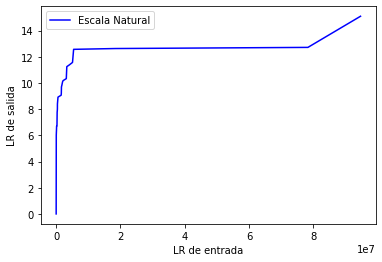

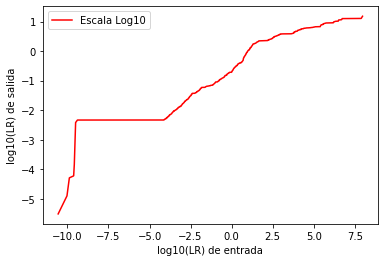

In [33]:
sistema4_Hp_calibrado_PAV, sistema4_Hd_calibrado_PAV = calibracion_PAV_curso(sistema4_Hp_train,
                                                                             sistema4_Hd_train,
                                                                             sistema4_Hp_test,
                                                                             sistema4_Hd_test);

**Observación**: Nuevamente obtuve resultados distintos a los esperados, por lo que utilizo los resultados de Matlab:

![calibracion-pav](./img/calibracion-pav.png)

### Antes de calibrar

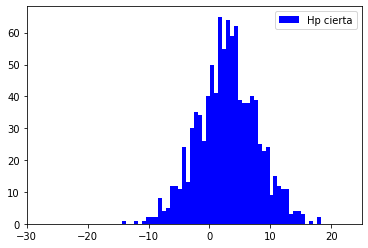

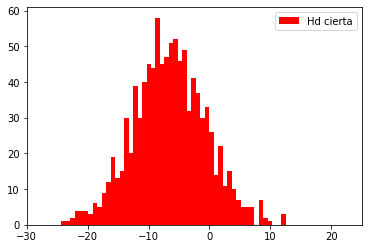

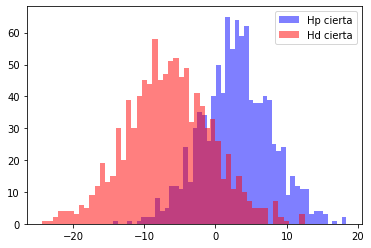

In [34]:
# Hp cierta
plt.hist(np.log(sistema4_Hp_test), bins=50, label='Hp cierta', color='b')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hd cierta
plt.hist(np.log(sistema4_Hd_test), bins=50, label='Hd cierta', color='r')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_test), bins=50, label='Hp cierta', color='b', alpha=0.5)
plt.hist(np.log(sistema4_Hd_test), bins=50, label='Hd cierta', color='r', alpha=0.5)
plt.legend()
plt.show()

### Luego de calibrar

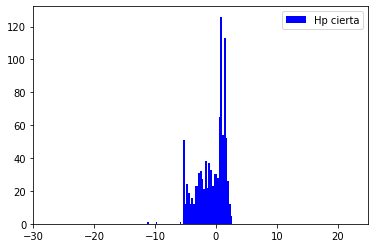

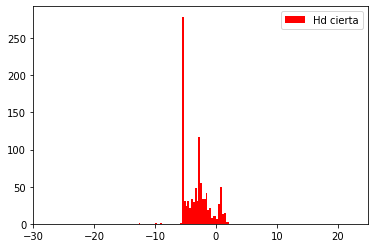

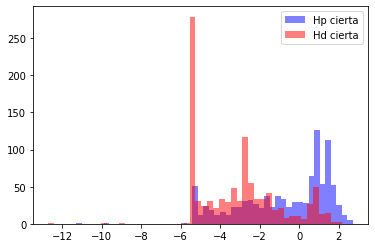

In [35]:
# Hp cierta
plt.hist(np.log(sistema4_Hp_calibrado_PAV), bins=50, label='Hp cierta', color='b')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hd cierta
plt.hist(np.log(sistema4_Hd_calibrado_PAV), bins=50, label='Hd cierta', color='r')
plt.xlim([-30, 25])
plt.legend()
plt.show()
# Hp,Hd on same plot
plt.hist(np.log(sistema4_Hp_calibrado_PAV), bins=50, label='Hp cierta', color='b', alpha=0.5)
plt.hist(np.log(sistema4_Hd_calibrado_PAV), bins=50, label='Hd cierta', color='r', alpha=0.5)
plt.legend()
plt.show()

Matlab para comparar:
### Antes de calibrar
![hist-pav-antes](./img/hist-pav-antes.png)
### Luego de calibrar
![hist-pav-calibrado](./img/hist-pav-calibrado.png)


# Pregunta:
> Comente el efecto de la calibración en las Tippett obtenidas.

Vemos como en un comienzo las distribuciones son simétricas en su media, mientras que luego de calibrar, sus áreas son "separadas" hacia los extremos (dejando de ser simétricas), para tener gran parte de sus área representativa lejos de sus intersecciones.

De esta forma se logra ser certero en la respuesta, con **menos incertidumbre**.



# Curvas APE

# Pregunta:

> Comente el efecto de la calibración en las APEs obtenidas.

### Antes de calibrar
![ape-pav-antes](./img/ape-pav-antes.png)
### Luego de de calibrar
![ape-pav-calibrado](./img/ape-pav-calibrado.png)

**Efectos de calibración:**

* Nuevamente vemos resultados similares a la calibración lineal, aunque con cierto **área de error** extra, cercano a la media.
* Se observa como el Bayes Error Rate (Pe, curva azul de area **Cross Entropy Loss** ($Cllr$)) se "acerca" al mínimo error (curva rayada $minCllr$)
* El area entre la curva azul y la rayada es la $calibration C_{llr}$
* El error de calibración se reduce considerablemente (área antes mencionada)